In [33]:
# Import Necessary Libraries
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import multivariate_normal, bernoulli, beta, norm
from scipy.stats import ks_2samp
from scipy.special import expit as logistic_sigmoid
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import cross_val_score
from sklearn.metrics import balanced_accuracy_score, brier_score_loss, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import KFold

In [34]:
# predicting goals per forward 
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix

data = pd.read_csv('combined_data.csv')
data = data[data['Position'].isin(['CF', 'RW' ,'LW'])]
# mean as a measure for binary
actions = np.mean(data['Successful actions'])
shots = np.mean(data['Shots on target'])
dribbles = np.mean(data['Successful dribbles'])
off_duels = np.mean(data['Offensive duels won'])
touches_in_penalty_area = np.mean(data['Touches in penalty area'])

# turn to binary
data['goals_binary'] = data['Goals'].apply(lambda x: 1 if x > 0 else 0)
data['actions_binary'] = data['Successful actions'].apply(lambda x: 1 if x >= actions else 0)
data['shots_binary'] = data['Shots on target'].apply(lambda x: 1 if x >= shots else 0)
data['dribbles_binary'] = data['Successful dribbles'].apply(lambda x: 1 if x >= dribbles else 0)
data['off_duels_binary'] = data['Offensive duels won'].apply(lambda x: 1 if x >= off_duels else 0)
data['touches_in_penalty_area_binary'] = data['Touches in penalty area'].apply(lambda x: 1 if x >= touches_in_penalty_area else 0)

Y = data['goals_binary']
X = data[['actions_binary', 'shots_binary', 'dribbles_binary', 'off_duels_binary', 'touches_in_penalty_area_binary']]
data['Position'].unique()


array(['RW', 'LW', 'CF'], dtype=object)

In [35]:
df = data.dropna().reset_index(drop=True)


In [36]:
goals_binary = data['goals_binary']

In [37]:

random_goals = goals_binary.sample(n=10, random_state=np.random.RandomState())

for index, player in enumerate(goals_binary, start=1):
    print(f"Player{index}': {player}\n")

Player1': 0

Player2': 0

Player3': 0

Player4': 0

Player5': 0

Player6': 0

Player7': 0

Player8': 0

Player9': 0

Player10': 0

Player11': 0

Player12': 0

Player13': 0

Player14': 0

Player15': 0

Player16': 0

Player17': 0

Player18': 1

Player19': 0

Player20': 0

Player21': 0

Player22': 0

Player23': 1

Player24': 0

Player25': 0

Player26': 0

Player27': 0

Player28': 0

Player29': 1

Player30': 0

Player31': 0

Player32': 0

Player33': 1

Player34': 0

Player35': 0

Player36': 1

Player37': 0

Player38': 0

Player39': 1

Player40': 1

Player41': 0

Player42': 0

Player43': 0

Player44': 0

Player45': 0

Player46': 0

Player47': 0

Player48': 0

Player49': 1

Player50': 0

Player51': 0

Player52': 0

Player53': 1

Player54': 0

Player55': 0

Player56': 0

Player57': 0

Player58': 0

Player59': 0

Player60': 0

Player61': 1

Player62': 0

Player63': 0

Player64': 1

Player65': 0

Player66': 0

Player67': 0

Player68': 1

Player69': 0

Player70': 0

Player71': 0

Player72': 0

P

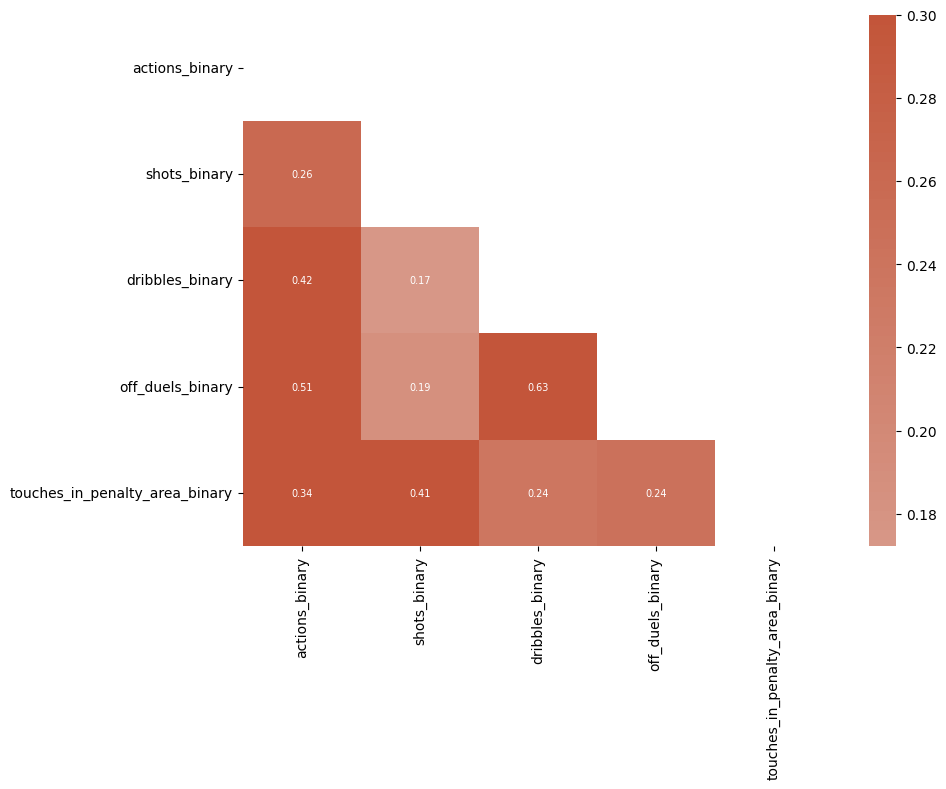

In [38]:
# Calculate the Correlation Matrix
corr = X.corr()

# Plotting
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True, fmt=".2f", annot_kws={"size": 7})
plt.tight_layout()
plt.show()

In [39]:
X_const = sm.add_constant(X)

# Get full dataset together 
YX_const =  pd.concat([goals_binary,X_const],axis = 1)

In [40]:
# Split data into validation and test (75:25)

# Calculate 25% of the dataset size
num_samples = YX_const.shape[0]* 25 // 100  # Using integer division to get an integer result

# Generate a list of all row IDs
# Assuming row IDs start at 0 and go up to dataset_size-1
row_ids = list(range(YX_const.shape[0]))

# Randomly select 25% of the row IDs
selected_row_ids = random.sample(row_ids, num_samples)

# Subset to create validation and test
YX_const_test = YX_const.iloc[YX_const.index.isin(selected_row_ids)] # the randomly chosen 25% goes to test-set
YX_const_val = YX_const.iloc[~YX_const.index.isin(selected_row_ids)] # the remaining 75% is our validation set

In [41]:
# Define predictors for each model variant
predictors = {
    'a': ['const'],
    'b': [col for col in X_const.columns if col != 'shots_binary'],
    'c': X_const.columns.tolist()
}

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import KFold

y = YX_const_val['goals_binary']  

# Initialize dictionaries to store scores
brier_scores = {key: [] for key in predictors}
acc_scores = {key: [] for key in predictors}
balanced_acc_scores = {key: [] for key in predictors}

# Setup the KFold cross-validation
K = 5 #GIVING K A K-FOLD VALUE
kf = KFold(n_splits=K, shuffle=True, random_state=42) 

for key, cols in predictors.items():
    for train_index, test_index in kf.split(YX_const_val):
        # Split the data according to the folds
        X_train, X_test = YX_const_val.iloc[train_index][cols], YX_const_val.iloc[test_index][cols]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit the logistic regression model with regularization
        model = LogisticRegression(C=1.0, solver='liblinear', random_state=42).fit(X_train, y_train)  # Adjust C as needed
        
        # Predict probabilities for the positive class
        y_pred_prob = model.predict_proba(X_test)[:, 1]

        # Calculate Brier score
        brier_score = brier_score_loss(y_test, y_pred_prob)
        brier_scores[key].append(brier_score)

        # Convert probabilities to binary predictions
        y_pred_binary = model.predict(X_test)

        # Calculate Accuracy and Balanced Accuracy Score
        acc_scores[key].append(accuracy_score(y_test, y_pred_binary))
        balanced_acc_scores[key].append(balanced_accuracy_score(y_test, y_pred_binary))

        
# Calculate and print the average scores for each model variant
results = []
for key in predictors.keys():
    results.append({
        'Model': key,
        'Average Brier Score': np.mean(brier_scores[key]),
        'Average Accuracy': np.mean(acc_scores[key]),
        'Average Balanced Accuracy': np.mean(balanced_acc_scores[key])
    })

# Convert results to DataFrame for nicer display
results_df = pd.DataFrame(results)
print(results_df)


  Model  Average Brier Score  Average Accuracy  Average Balanced Accuracy
0     a             0.186479          0.752084                   0.500000
1     b             0.168092          0.752084                   0.500000
2     c             0.120444          0.784504                   0.755394


In [43]:
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

Coefficients: [[-3.3112822   0.1521631   6.29470225  0.02184951 -0.26494288  0.53069861]]
Intercept: [-3.3112822]


In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss

exclude_column = 'Shots on target'  
# Define the predictors for model 'b'
predictors_b = [col for col in X_const.columns if col != exclude_column]

# Subset the full validation set for these predictors
X_val_b = YX_const_val[predictors_b]
y_val = YX_const_val['goals_binary']  # Target variable

# Fit the logistic regression model to the full validation set
model_b = LogisticRegression(random_state=42).fit(X_val_b, y_val)

# Predict probabilities and binary outcomes on the same validation set to evaluate performance
y_pred_prob_b = model_b.predict_proba(X_val_b)[:, 1]
y_pred_b = model_b.predict(X_val_b)

# Calculate performance metrics
accuracy_b = accuracy_score(y_val, y_pred_b)
log_loss_b = log_loss(y_val, y_pred_prob_b)

print(f"Accuracy for model 'b': {accuracy_b}")
print(f"Log Loss for model 'b': {log_loss_b}")


Accuracy for model 'b': 0.7851660711922721
Log Loss for model 'b': 0.3354860440341679
